# Jellium
[?](?)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


ModuleNotFoundError: No module named 'mendeleev'


### Set Parameters in Paper and Plot

In [4]:
name = 'Jellium'
Z, A = 1,1 

Te_eV = 1 # eV
rs_AU = 1
rs_cm = rs_AU/cm_to_AU
ne_cc = n_from_rs(rs_cm)


#### Run Ornstein-Zernike Closure

In [5]:
P_hnc_to_bar = lambda P_hnc: (P_hnc/rs_AU**3) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)

def get_jellium_P_Mbar(jellium_hnc):
    # jellium_hnc.h_r_matrix -= 1
    P_hnc = jellium_hnc.excess_pressure_matrix()
    # jellium_hnc.h_r_matrix += 1
    return P_hnc_to_Mbar(P_hnc)[0,0]


In [19]:
jellium = PLASMA(1, 1, ne_cc, 1, Te_eV, Zbar=1, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

jellium.run_jellium_hnc()
# Reset βvee
βvee_Pauli   = jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee )
βvee_Pauli   = jellium.βP_ee
βvee_Deutsch = jellium.qsp.βv_Deutsch( jellium.qsp.Γee, jellium.jellium_hnc.r_array , jellium.qsp.Λee )
jellium.jellium_hnc.set_βu_matrix(np.array([[βvee_Pauli + βvee_Deutsch ]]))
jellium.jellium_hnc.HNC_solve(**jellium.hnc_solve_options)



Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 9.267e-02
Exiting status 0, reverting to best index so far: 35
Final iter:36, Total Error: 6.570e-09
0: Initial condition Total Error: 6.570e-09
Exiting status 0, reverting to best index so far: 1
Final iter:2, Total Error: 4.207e-09


0

#### Pressures

In [21]:
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))
jellium.jellium_hnc.βu_r_matrix[0,0] -= jellium.βP_ee
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))
jellium.jellium_hnc.βu_r_matrix[0,0] += jellium.βP_ee
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))

[[7445.15100437]]
[[6980.3762154]]
[[7445.15100437]]


In [8]:
P_Fermi_Mbar = 2/5 * jellium.qsp.E_F/(4/3*π*(jellium.qsp.ri)**3) * AU_to_bar/1e6

P_hnc_to_Mbar(jellium.jellium_hnc.ideal_pressure()),get_jellium_P_Mbar( jellium.jellium_hnc), P_Fermi_Mbar

(51.803654302600016, 465.74712400603397, 51.739302540025804)

##### Plot Radial Dsitribution Function

Missing colon in file '~/plasma/hnc/hnc_paper.mplstyle', line 40 ("text.latex.preamble = r'\\boldmath'")


(0.0, 5.0)

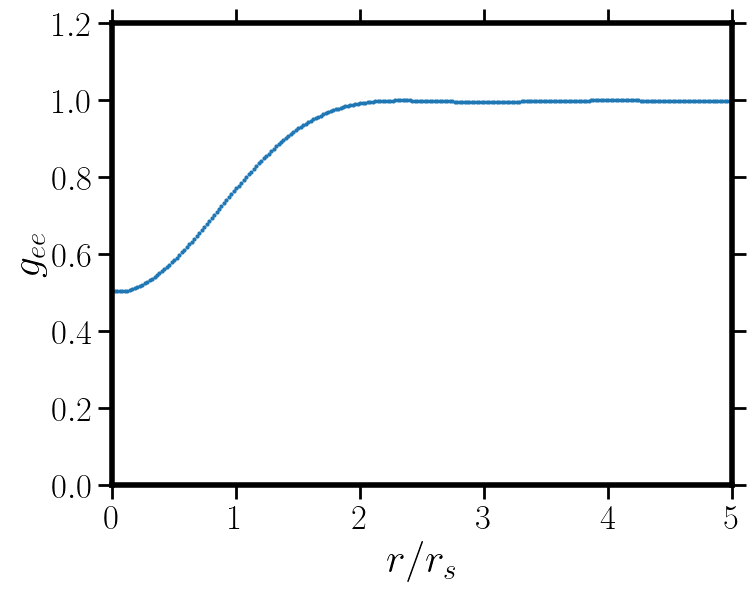

In [9]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.jellium_hnc.h_r_matrix[0,0]+1,'.', label='Default Pauli')
# ax.plot(jellium.jellium_hnc.r_array, jellium.jellium_hnc.h_r_matrix[0,0]+1, label='Default Pauli')


ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$g_{ee}$")

ax.set_ylim(0,1.2)
ax.set_xlim(0,5)

#### Plot βu

Missing colon in file '~/plasma/hnc/hnc_paper.mplstyle', line 40 ("text.latex.preamble = r'\\boldmath'")


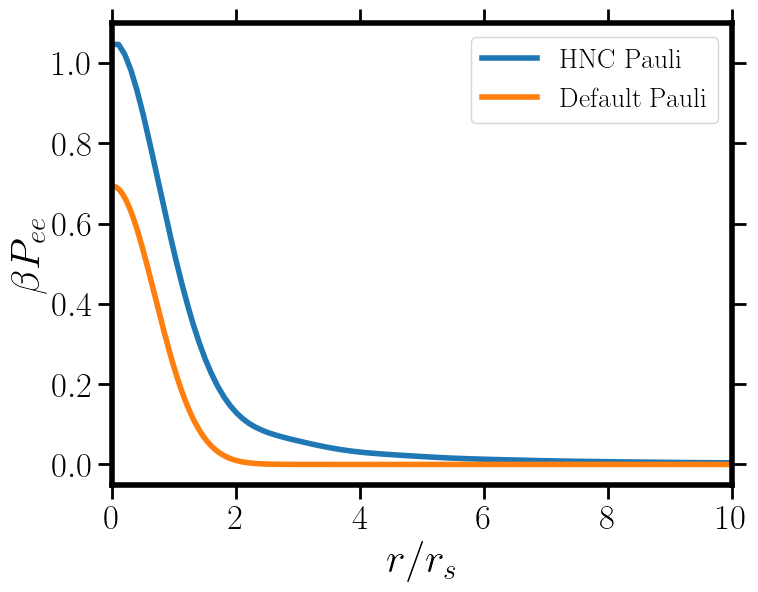

In [10]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.βP_ee, label='HNC Pauli')
ax.plot(jellium.jellium_hnc.r_array, jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee ), label='Default Pauli')

ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$\beta P_{ee}$")

# ax.set_ylim(0,1.2)
ax.set_xlim(0,10)
ax.legend()